In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from sklearn.metrics import roc_auc_score
from keras import regularizers

In [483]:
word2vec = {}
with open (os.path.join("glove.twitter.27B.25d.txt"), encoding='utf-8') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vec = np.asarray(values[1:], dtype="float32")
        word2vec[word] =vec    

KeyboardInterrupt: 

Set up the Data

# BAG OF WORDS MODEL

In [ ]:
df = pd.read_csv("data/curated_extreme_data.csv")
df.head()

,Unnamed: 0,amitheasshole,todayilearned,explainlikeimfive,news,askreddit,cornell
0,0,AITA for telling my wife the lock on my daught...,TIL that slaveholders in the US knew that ensl...,ELI5:How after 5000 years of humanity survivin...,Joe Biden elected president of the United States,"People who haven't pooped in 2019 yet, why are...",Cornell Alert: Anyone know whats going on?
1,1,META: This sub is moving towards a value syste...,"TIL During an interview with Stephen Hawking, ...",We call upon Reddit to take action against the...,"Chauvin found guilty of murder, manslaughter i...",How would you feel about Reddit adding 3 NSFW ...,I threw up in my mask and had to continue taki...
2,2,"UPDATE, AITA for despising my mentally handica...",TIL Genghis Khan would marry off a daughter to...,ELI5: How did we get to the point where laptop...,President Donald Trump says he has tested posi...,Would you watch a show where a billionaire CEO...,this professor gets it
3,3,AITA For suing my girlfriend after she had my ...,TIL the FBI has struggled to hire hackers beca...,ELI5: Stock Market Megathread,Blizzard Employees Staged a Walkout After the ...,"What if God came down one day and said ""It's p...",An actual summary of the 97 page report
4,4,UPDATE: AITA for wanting to go to the funeral ...,"TIL After Col. Shaw died in battle, Confederat...",ELI5: So how does the the human brain ignore t...,Trump has left the White House for the last ti...,How would you feel about a feature where if so...,I am a New Bus!


In [ ]:
possible_labels = ['amitheasshole','todayilearned','explainlikeimfive','news','askreddit','cornell']

train = pd.DataFrame()
train['title'] = []
train['index'] = []

for label in df.columns[1:]:
    for sentence in df[label]:
        train = train.append({'title': sentence, 'index':possible_labels.index(label)},ignore_index=True)
        train = train.fillna(0)

train.head()

,title,index
0,AITA for telling my wife the lock on my daught...,0.0
1,META: This sub is moving towards a value syste...,0.0
2,"UPDATE, AITA for despising my mentally handica...",0.0
3,AITA For suing my girlfriend after she had my ...,0.0
4,UPDATE: AITA for wanting to go to the funeral ...,0.0


In [ ]:
import numpy as np
from sklearn import model_selection
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer
 
vectorizer = CountVectorizer()

X = train['title']
y = train['index']

X = np.array([item if not isinstance(item, int) else str(item) for item in X])

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size= 0.2, random_state = 1)

print('X_train dimension= ', X_train.shape)
print('X_test dimension= ', X_test.shape)
print('y_train dimension= ', y_train.shape)
print('y_train dimension= ', y_test.shape)

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

X_train dimension=  (4795,)
X_test dimension=  (1199,)
y_train dimension=  (4795,)
y_train dimension=  (1199,)


In [ ]:
lm = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')
lm.fit(X_train, y_train)

LogisticRegression(multi_class='ovr', solver='liblinear')

In [ ]:
(lm.predict(X_test) == y_test).mean()

0.957464553794829

In [504]:
test_title = "Saw Martha Pollack sleeping in the cocktail lounge"
index = int(lm.predict(vectorizer.transform([test_title]))[0])
print('Message: ' + test_title)
print(possible_labels[index])

Message: Saw Martha Pollack sleeping in the cocktail lounge
cornell


Preprocessing and Tokenizing

In [505]:
MAX_SEQUENCE_LENGTH= 30
MAX_VOCAB_SIZE =20000
EMBEDDING_DIM=25
VALIDATION_SPLIT =0.2
BATCH_SIZE =200
EPOCHS = 20

In [506]:
from keras.preprocessing.text import Tokenizer

sentences = train["title"].fillna("NO_TITLE_EMPTY").values
sentences = [item for item in sentences if not isinstance(item, int)]
targets = train[possible_labels].values

tokenizer= Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
#sequences
#tokenizer.word_index
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

KeyError: "None of [Index(['amitheasshole', 'todayilearned', 'explainlikeimfive', 'news',\n       'askreddit', 'cornell'],\n      dtype='object')] are in the [columns]"

Preprocessing the Data Text

In [ ]:
print("max sequence length:", max(len(s) for s in sequences))
print("min sequence length:", min(len(s) for s in sequences))
s = sorted(len(s) for s in sequences)
print("median sequence length:", s[len(s) // 2])

print("max word index:", max(max(seq) for seq in sequences if len(seq) > 0))


# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

max sequence length: 62
min sequence length: 0
median sequence length: 15
max word index: 14263
Found 14263 unique tokens.


In [ ]:
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False
)

In [ ]:
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,)) #Dimensions

x=embedding_layer(input_)

x=Dense(128,activation="relu",kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.L2(1e-4),
    activity_regularizer=regularizers.L2(1e-5))(x)


x=Conv1D(128,2,activation="relu")(x)
x=MaxPooling1D(2)(x)

x=Conv1D(128,2,activation="relu")(x)
x=MaxPooling1D(2)(x)

x=Conv1D(128,2,activation="relu")(x)
x=GlobalMaxPooling1D()(x)

output=Dense(len(possible_labels), activation="sigmoid")(x)

In [ ]:
model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)

## Train the Model

In [ ]:
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Epoch 1/10
24/24 [==============================] - 3s 63ms/step - loss: 0.3511 - accuracy: 0.5989 - val_loss: 0.8975 - val_accuracy: 0.0608
Epoch 2/10
24/24 [==============================] - 1s 54ms/step - loss: 0.2163 - accuracy: 0.7786 - val_loss: 0.9067 - val_accuracy: 0.1333
Epoch 3/10
24/24 [==============================] - 1s 51ms/step - loss: 0.1862 - accuracy: 0.8198 - val_loss: 1.0614 - val_accuracy: 0.0852
Epoch 4/10
24/24 [==============================] - 1s 54ms/step - loss: 0.1644 - accuracy: 0.8529 - val_loss: 1.0208 - val_accuracy: 0.1646
Epoch 5/10
24/24 [==============================] - 1s 59ms/step - loss: 0.1443 - accuracy: 0.8717 - val_loss: 1.2013 - val_accuracy: 0.1156
Epoch 6/10
24/24 [==============================] - 1s 60ms/step - loss: 0.1384 - accuracy: 0.8723 - val_loss: 1.2114 - val_accuracy: 0.1460
Epoch 7/10
24/24 [==============================] - 1s 57ms/step - loss: 0.1256 - accuracy: 0.8947 - val_loss: 1.3580 - val_accuracy: 0.1342
Epoch 8/10
24

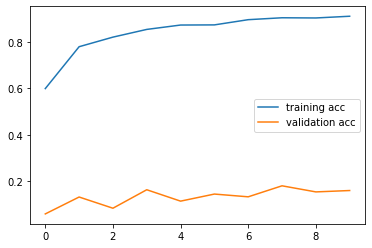

In [ ]:
acc = r.history['accuracy']
val_acc = r.history['val_accuracy']
loss = r.history['loss']
val_loss = r.history['val_loss']
plt.plot(acc,label="training acc")
plt.plot(val_acc,label="validation acc")
plt.legend()

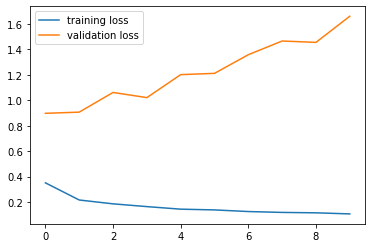

In [ ]:
plt.plot(loss,label="training loss")
plt.plot(val_loss,label="validation loss")
plt.legend()

In [ ]:
test_text = "TIFU by not making a good model"
test_seq = tokenizer.texts_to_sequences(test_text)
test_pad = pad_sequences(test_seq,maxlen=MAX_SEQUENCE_LENGTH)
subreddits=model.predict(test_pad)[0]

In [ ]:
len(possible_labels)

6

In [ ]:
for i in range(0,6):
    print(subreddits[i] ,possible_labels[i])

0.37851483 amitheasshole
0.33201912 todayilearned
0.46514106 explainlikeimfive
0.48738322 news
0.443127 askreddit
0.21631321 cornell


In [ ]:
from keras import Sequential
from keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D
filter_length = 300
model = Sequential()
model.add(Embedding(MAX_VOCAB_SIZE, 20, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filter_length, 3, padding='valid', activation='relu', strides=1))
# model.add(GlobalMaxPool1D())
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(len(possible_labels), kernel_regularizer=regularizers.L1L2(l1=0, l2=0),
    bias_regularizer=regularizers.L2(0),
    activity_regularizer=regularizers.L2(0)),)
model.add(Activation('softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tf.keras.metrics.Accuracy()])

In [ ]:
preds = model.predict(data)

In [ ]:
preds

array([[0.16708349, 0.16757613, 0.16665903, 0.16510461, 0.16647993,
        0.16709676],
       [0.16633329, 0.16755427, 0.16724212, 0.16742693, 0.16508956,
        0.16635382],
       [0.1666036 , 0.16705026, 0.16710675, 0.1662994 , 0.16647196,
        0.166468  ],
       ...,
       [0.1667107 , 0.16699247, 0.16665937, 0.16702671, 0.16670103,
        0.16590966],
       [0.1659875 , 0.16693318, 0.16721632, 0.16656658, 0.16742608,
        0.16587032],
       [0.16535059, 0.1680991 , 0.166688  , 0.16599217, 0.16750322,
        0.16636692]], dtype=float32)

In [ ]:
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=60,
  validation_split=VALIDATION_SPLIT
)

Epoch 1/60
24/24 [==============================] - 4s 140ms/step - loss: 1.7875 - accuracy: 0.0000e+00 - val_loss: 1.8314 - val_accuracy: 0.0000e+00
Epoch 2/60
24/24 [==============================] - 3s 131ms/step - loss: 1.7725 - accuracy: 0.0000e+00 - val_loss: 1.8929 - val_accuracy: 0.0000e+00
Epoch 3/60
24/24 [==============================] - 3s 140ms/step - loss: 1.7572 - accuracy: 0.0000e+00 - val_loss: 1.9550 - val_accuracy: 0.0000e+00
Epoch 4/60
24/24 [==============================] - 3s 140ms/step - loss: 1.7430 - accuracy: 0.0000e+00 - val_loss: 2.0174 - val_accuracy: 0.0000e+00
Epoch 5/60
24/24 [==============================] - 3s 132ms/step - loss: 1.7296 - accuracy: 0.0000e+00 - val_loss: 2.0810 - val_accuracy: 0.0000e+00
Epoch 6/60
24/24 [==============================] - 3s 135ms/step - loss: 1.7168 - accuracy: 0.0000e+00 - val_loss: 2.1455 - val_accuracy: 0.0000e+00
Epoch 7/60
24/24 [==============================] - 4s 148ms/step - loss: 1.7043 - accuracy: 0.0000e

KeyboardInterrupt: 

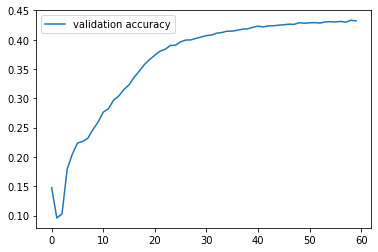

In [ ]:
acc = r.history['auc_9']
val_acc = r.history['val_auc_9']
loss = r.history['loss']
val_loss = r.history['val_loss']
plt.plot(val_acc,label="validation accuracy")
plt.legend()

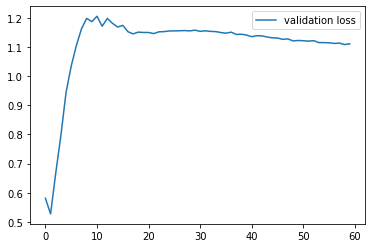

In [ ]:
plt.plot(val_loss,label="validation loss")
plt.legend()

In [ ]:
test_text = "Vladmir Putin Barack Obama Biden"
test_seq = tokenizer.texts_to_sequences(test_text)
test_pad = pad_sequences(test_seq,maxlen=MAX_SEQUENCE_LENGTH)
subreddits = model.predict(test_pad)[0]
for i in range(0,6):
    print(subreddits[i] ,possible_labels[i])


0.15671366 amitheasshole
0.00015318394 todayilearned
0.06224823 explainlikeimfive
0.9195009 news
0.63325363 askreddit
0.02682513 cornell


In [ ]:
from tensorflow.keras.optimizers import SGD
from keras import Sequential
from keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D
filter_length = 300
model = Sequential()
model.add(Embedding(MAX_VOCAB_SIZE, 128, input_length=MAX_SEQUENCE_LENGTH))
model.add(Flatten())
model.add(Dense(1024, kernel_regularizer=regularizers.L1L2(l1=0, l2=0), activation='relu'))
model.add(Dense(1024, kernel_regularizer=regularizers.L1L2(l1=0, l2=0), activation='relu'))
model.add(Dense(len(possible_labels), kernel_regularizer=regularizers.L1L2(l1=0, l2=0)))
model.add(Activation('softmax'))
model.compile(optimizer=SGD(learning_rate=1e-3, momentum=0.5), loss='categorical_crossentropy', metrics=[tf.keras.metrics.Accuracy()])

In [ ]:
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Epoch 1/20
24/24 [==============================] - 2s 82ms/step - loss: 1.7926 - accuracy: 0.0000e+00 - val_loss: 1.7841 - val_accuracy: 0.0000e+00
Epoch 2/20
24/24 [==============================] - 2s 75ms/step - loss: 1.7874 - accuracy: 0.0000e+00 - val_loss: 1.8006 - val_accuracy: 0.0000e+00
Epoch 3/20
24/24 [==============================] - 2s 78ms/step - loss: 1.7824 - accuracy: 0.0000e+00 - val_loss: 1.8167 - val_accuracy: 0.0000e+00
Epoch 4/20
24/24 [==============================] - 2s 79ms/step - loss: 1.7776 - accuracy: 0.0000e+00 - val_loss: 1.8327 - val_accuracy: 0.0000e+00
Epoch 5/20
24/24 [==============================] - 2s 79ms/step - loss: 1.7729 - accuracy: 0.0000e+00 - val_loss: 1.8484 - val_accuracy: 0.0000e+00
Epoch 6/20
24/24 [==============================] - 2s 87ms/step - loss: 1.7683 - accuracy: 0.0000e+00 - val_loss: 1.8639 - val_accuracy: 0.0000e+00
Epoch 7/20
24/24 [==============================] - 2s 84ms/step - loss: 1.7638 - accuracy: 0.0000e+00 - v

In [ ]:
model.predict(data)

array([[5.9057558e-01, 1.9254258e-01, 1.0769456e-01, 2.7539555e-02,
        7.3988631e-02, 7.6590688e-03],
       [1.0244011e-01, 7.2670758e-02, 4.0564093e-01, 1.4615299e-01,
        2.7197471e-01, 1.1205078e-03],
       [7.0337605e-01, 3.5947617e-03, 4.2458475e-02, 1.9327883e-01,
        5.7123974e-02, 1.6783753e-04],
       ...,
       [2.3350449e-01, 8.5974531e-03, 1.2069647e-01, 4.9033317e-01,
        1.4656126e-01, 3.0713264e-04],
       [1.2542683e-01, 5.2054827e-03, 1.4830206e-01, 4.9780041e-01,
        2.2298378e-01, 2.8144330e-04],
       [1.5921834e-01, 1.2794484e-01, 4.0015128e-01, 9.9179201e-02,
        2.1064202e-01, 2.8642747e-03]], dtype=float32)